# Tratamiento de datos COVID-10
## Objeto
Se tratarán los datos de la [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) que se traem al directorio $data_dir. 

Se utilizarán tablas de población para, en el futuro, obtener información más relevante

## Obtención de datos
Se obtienen los datos de población desde los repositorios de Naciones Unidas.

Los datos de contagios y fallecidos por COVID-19 se traen del repositorio mantenido por la Universidad Johns Hopkins

In [1]:
data_dir = './data'
covid_dir = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
covid_git_url = 'https://github.com/CSSEGISandData/COVID-19'
population_file = 'WPP2019_PopulationByAgeSex_Medium.csv'
covid_confirmed_file = 'time_series_covid19_confirmed_global.csv'
covid_deaths_file = 'time_series_covid19_deaths_global.csv'
un_pop_repo_url = 'https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/' + population_file

! if [ ! -d '{data_dir}' ]; then echo 'No existe directorio de datos. Creándolo...'; mkdir '{data_dir}' ; fi
! if [ ! -d '{data_dir}/{covid_dir}' ]; then echo 'No existe clone del repositorio {covid_dir}. Ejecutando git clone {covid_git_url}'; cd '{data_dir}';  git clone '{covid_git_url}'; fi
! if [ ! -f '{data_dir}/{population_file}' ]; then echo 'No existen datos de población Trayéndolos de {un_pop_repo_url}'; cd '{data_dir}'; curl -g '{un_pop_repo_url}' -o $population_file; fi

## Actualización de ficheros

In [2]:
! cd '{data_dir}/{covid_dir}'; git pull
! ls -l '{data_dir}/{covid_dir}/'

remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 102 (delta 67), reused 69 (delta 67), pack-reused 32
Receiving objects: 100% (102/102), 580.49 KiB | 1.53 MiB/s, done.
Resolving deltas: 100% (69/69), completed with 20 local objects.
From https://github.com/CSSEGISandData/COVID-19
   4262ab59b..c7e674f3a  master     -> origin/master
 * [new branch]          automated-patch-for-delayed-data-for-US-01-20-2021 -> origin/automated-patch-for-delayed-data-for-US-01-20-2021
   36ffa5b5e..3744ff130  web-data   -> origin/web-data
Updating 4262ab59b..c7e674f3a
Fast-forward
 csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv   |   1 +
 .../csse_covid_19_daily_reports/01-20-2021.csv     |  86 +--
 .../csse_covid_19_daily_reports_us/01-20-2021.csv  |   2 +-
 .../time_series_covid19_confirmed_US.csv           | 640 ++++++++++-----------
 .../time_series_covid19_confirmed_global.csv       |   2 +-
 .../time_

## Importación de datos
Lo primero es común a todos los programas que traten datos

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np

Se utiliza Pandas para leer el fichero csv. Las columnas que notienen datos (las 4 primeras), se ponen de índice. 

Se van a leer los datos de fallecimientos y de casso confirmados

In [4]:
deaths = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_deaths_file, 
                      index_col=[0,1,2,3])
confirmed = pd.read_csv(data_dir + '/' + covid_dir + '/' + covid_confirmed_file, 
                           index_col=[0,1,2,3])
population = pd.read_csv (data_dir + '/' + population_file)

## Tratamiento de datos
Se filtran los datos de población para suprimir la división por edades y quedarnos con los del año 2021. 
Se conserva la división por género por si tuviese interés

In [5]:
pop_filtered = population[(population['VarID'] == 2) & (population['Time'] == 2021) ] \
                         [['Location','PopMale','PopFemale','PopTotal']] \
                         .groupby(['Location']).sum()

#population.head()
#pop_filtered.index.names

pop_filtered.loc['Spain']
pop_filtered.head(3)

,PopMale,PopFemale,PopTotal
Location,,,
Afghanistan,20434.981,19400.447,39835.428
Africa,686414.950,687071.522,1373486.472
African Group,685518.459,686168.843,1371687.302


Se cambia el nombre de algunos índices. Se ha visto que el nombre de los países es distinto en las tablas de la 
ONU que en las tablas COVID. Por ejemplo, los **Estados Unidos de América** aparecen en las tablas de la ONU
como **United States of America**, mientras que en las tablas COVID como **US**. El diccionario **change_dict**
está pensado para todos estos casos.

In [6]:
change_dict = {
    'United States of America': 'US',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Russian Federation': 'Russia'
              }

pop_index_list = pop_filtered.index.tolist()

for country in change_dict:
    pop_index_list[pop_index_list.index(country)] = change_dict[country]

pop_filtered.index = pop_index_list

In [7]:
pop_filtered.loc[['US',
                  'Spain',
                  'Morocco',
                  'United Kingdom',
                  'Ireland',
                  'Italy',
                  'Germany',
                  'France',
                  'Argentina',
                  'Chile',
                  'Mexico',
                  'Peru',
                  'Colombia', 
                  'Venezuela', 
                  'Cuba', 
                  'Bolivia', 
                  'Ecuador', 
                  'Guatemala', 
                  'Panama', 
                  'Costa Rica',
                  'Russia',
                  'China']].sort_values('PopTotal', ascending=False)

,PopMale,PopFemale,PopTotal
China,740521.760,703694.342,1444216.102
US,164729.431,168185.643,332915.074
Russia,67638.243,78273.779,145912.022
Mexico,63724.708,66537.512,130262.220
Germany,41500.151,42400.320,83900.471
United Kingdom,33716.291,34490.823,68207.114
France,31662.586,33763.591,65426.177
Italy,29411.239,30956.232,60367.471
Colombia,25171.408,26094.433,51265.841
Spain,22979.101,23766.110,46745.211


Se obtienen los dataframes de incrementos por población

In [8]:
deaths_sum = deaths.groupby(level=1).sum()
confirmed_sum = confirmed.groupby(level=1).sum()


def get_by_pop_inc_df (df,pop):
    df_by_pop_inc = df.divide(pop_filtered['PopTotal']/(pop/1000), axis=0).transpose().diff()
    df_by_pop_inc.index = pd.to_datetime(df_by_pop_inc.index)
    return df_by_pop_inc
    
confirmed_sum_by_pop_inc = get_by_pop_inc_df(confirmed_sum,100000)
deaths_sum_by_pop_inc = get_by_pop_inc_df(deaths_sum,1000000)



confirmed_sum_by_pop_inc['Spain']
#confirmed_100K = confirmed_sum.loc['Spain'].diff() / (pop_filtered.loc['Spain']['PopTotal'] /100)
#confirmed_100K.rolling(min_periods=1, window=7).sum().tail(35)

2020-01-22           NaN
2020-01-23      0.000000
2020-01-24      0.000000
2020-01-25      0.000000
2020-01-26      0.000000
                 ...    
2021-01-16      0.000000
2021-01-17      0.000000
2021-01-18    180.311519
2021-01-19     73.357247
2021-01-20     88.941731
Name: Spain, Length: 365, dtype: float64

## Gráficos

Se obtienen gráficos para fallecimientos y casos confirmados utilizando ventanas deslizantes de
longitud variable (**confirmed_window** y **deaths_window**) para casos confirmados y fallecimientos.
Se ha comprobadoque los datos presentan fuerte correlación con el día de la semana. Por elllo,
Cualquier longitud de ventana que no sea múltiplo de 7 causa dientes de sierra.

Los países para los cuales se desean los gráficos están en el array **interesting_countries**.

El último dato es el de la fecha en la que se ejecuta el notebook (**todate = today**). El primero de 
los datos es el de hace **nweeks** (configurable) semanas.

La escala en y puede ser logarítimca (**logaritmic = True**) o no (**logaritmic = False**).

El tamaño del gráfico se configura con **fsize**. Se trata de una dupla en el que el primer
componente es el tamaño del eje x y el segundo el del eje y.

<AxesSubplot:title={'center':'Fallecimientos en últimos 7.0 días por millón de habitantes'}>

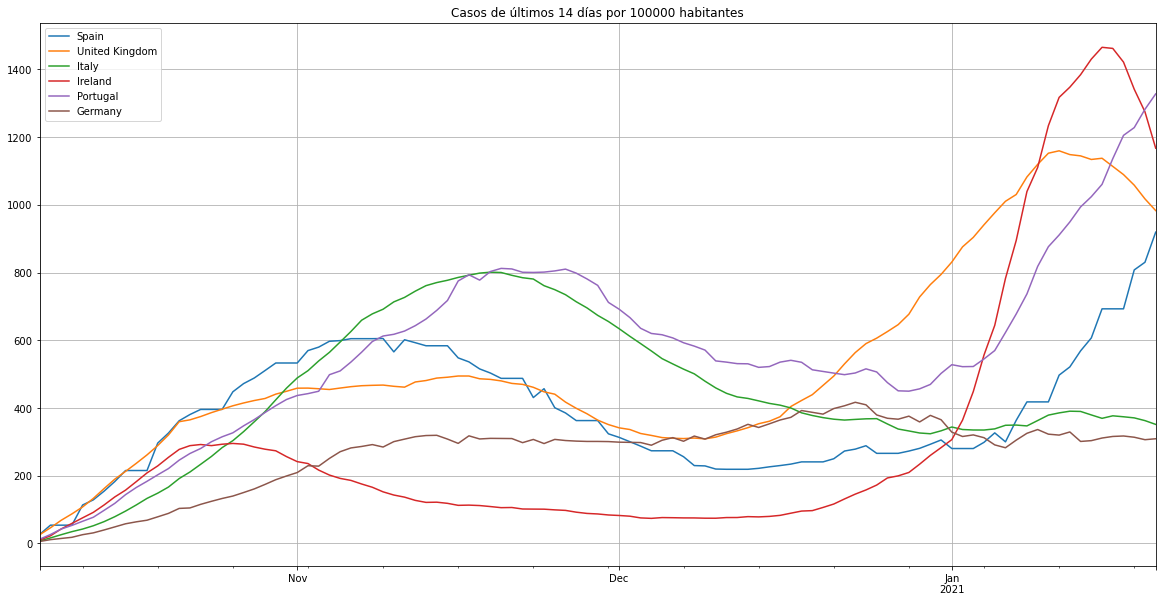

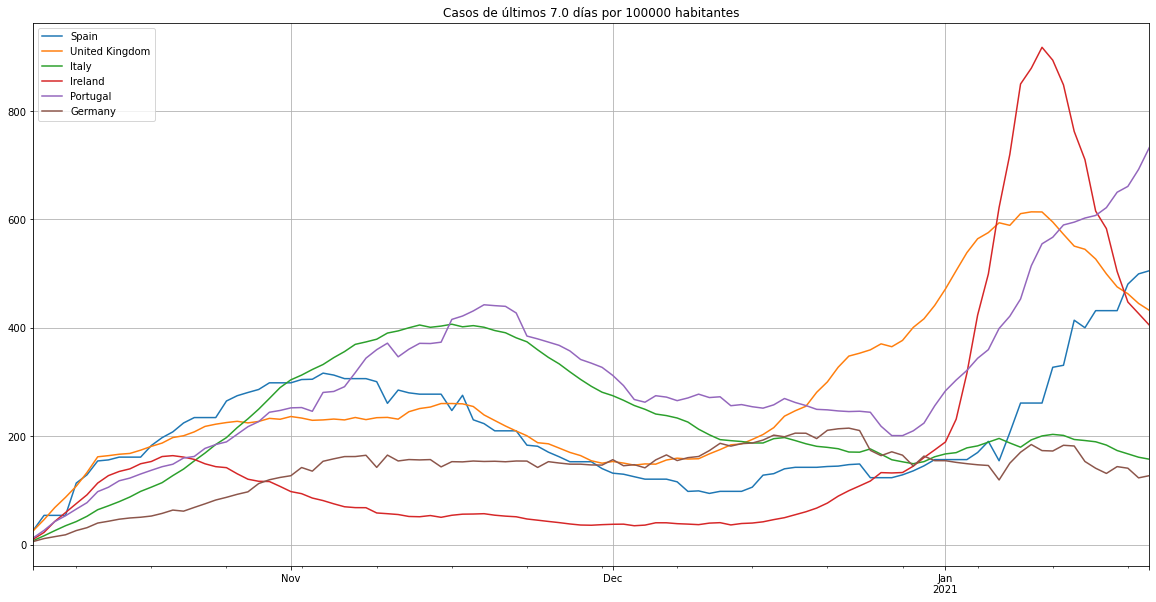

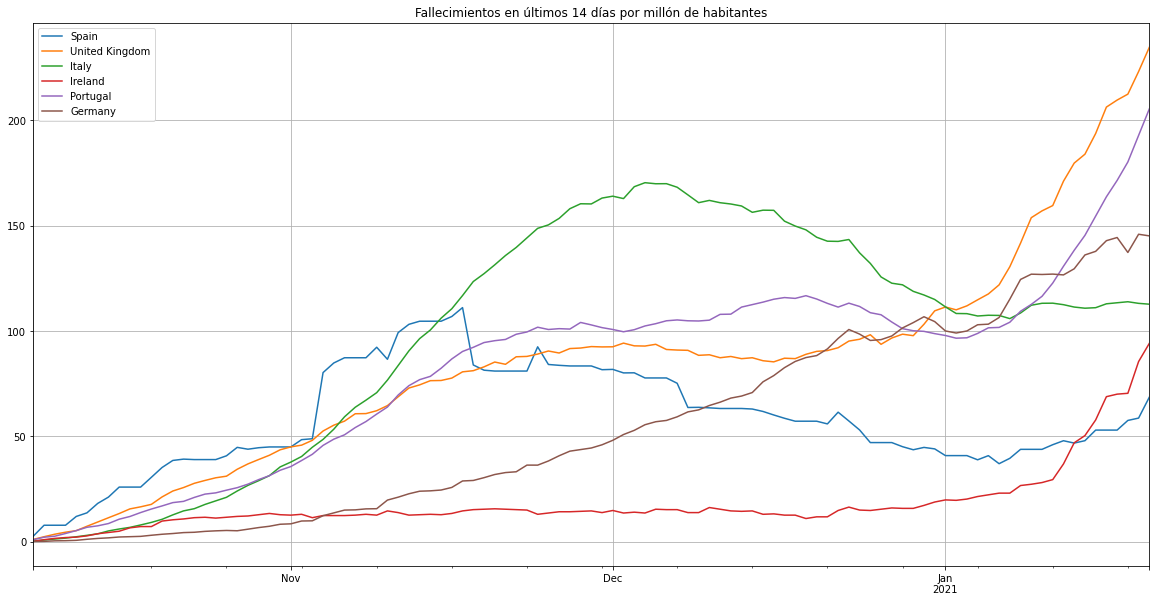

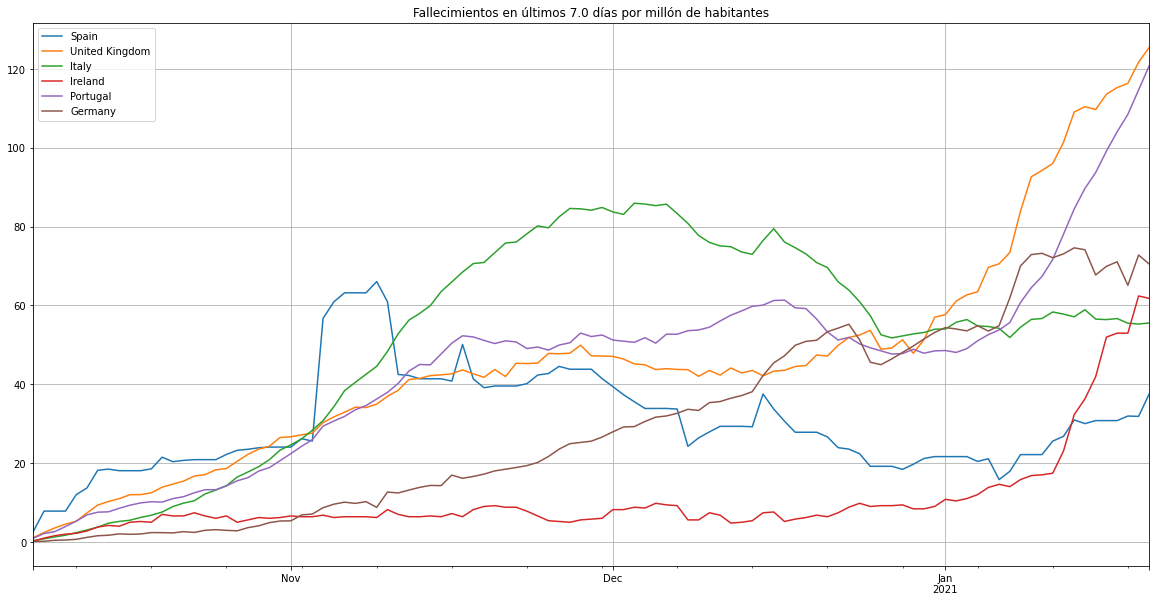

In [9]:
import datetime

nweeks=15
interesting_countries = ['Spain','United Kingdom', 'Italy' , 'Ireland', 'Portugal', 'Germany' ]

today = datetime.date.today()
#yesterday = today - datetime.timedelta(days=1)
fromdate=today - datetime.timedelta(weeks=nweeks)
todate=today
fsize=(20,10)
logaritmic = False
confirmed_window = 14
deaths_window = 14

confirmed_sum_by_pop_inc[fromdate:todate].rolling(min_periods=1, window=confirmed_window).sum()[interesting_countries].plot(
                                              title='Casos de últimos {} días por 100000 habitantes'.format(confirmed_window), 
                                              figsize=fsize, 
                                              logy=logaritmic,
                                              grid=True
                                             )
confirmed_sum_by_pop_inc[fromdate:todate].rolling(min_periods=1, window=int(confirmed_window/2)).sum()[interesting_countries].plot(
                                              title='Casos de últimos {} días por 100000 habitantes'.format(confirmed_window/2), 
                                              figsize=fsize, 
                                              logy=logaritmic,
                                              grid=True
                                             )
deaths_sum_by_pop_inc[fromdate:todate].rolling(min_periods=1, window=deaths_window).sum()[interesting_countries].plot(
                                               title='Fallecimientos en últimos {} días por millón de habitantes'.format(deaths_window), 
                                               figsize=fsize, 
                                               logy=logaritmic,
                                               grid=True
                                              )
deaths_sum_by_pop_inc[fromdate:todate].rolling(min_periods=1, window=int(deaths_window/2)).sum()[interesting_countries].plot(
                                               title='Fallecimientos en últimos {} días por millón de habitantes'.format(deaths_window/2), 
                                               figsize=fsize, 
                                               logy=logaritmic,
                                               grid=True
                                              )